# Test ES-Image
@timdittmann 

Goal of ES image is to support  earthscope data processing

## Test pygmt

In [ ]:
#https://www.pygmt.org/latest/tutorials/basics/coastlines.html#sphx-glr-tutorials-basics-coastlines-py
import pygmt
fig = pygmt.Figure()
fig.basemap(region="g", projection="W15c", frame=True)
fig.coast(shorelines=True)
fig.show()

## Test Obspy with IRIS data

In [1]:
#https://docs.obspy.org/packages/obspy.clients.fdsn.html
from obspy.clients.fdsn import Client
client = Client("IRIS")

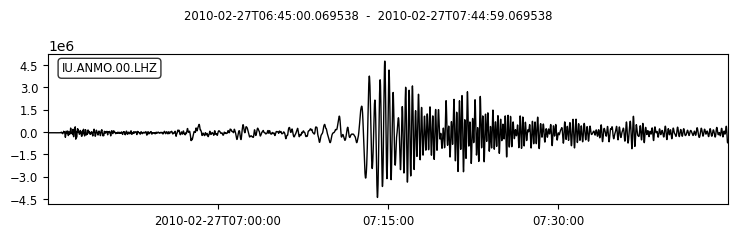

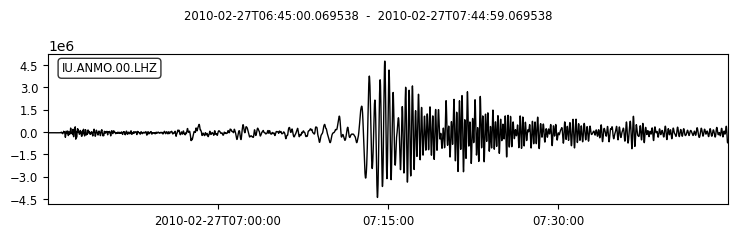

In [2]:
from obspy import UTCDateTime
t = UTCDateTime("2010-02-27T06:45:00.000")
st = client.get_waveforms("IU", "ANMO", "00", "LHZ", t, t + 60 * 60)
st.plot() 

2 Event(s) in Catalog:
2002-01-01T11:29:22.720000Z |  +6.282, +125.749 | 6.3  MW
2002-01-01T07:28:57.480000Z | +36.991,  +72.336 | 6.3  Mb


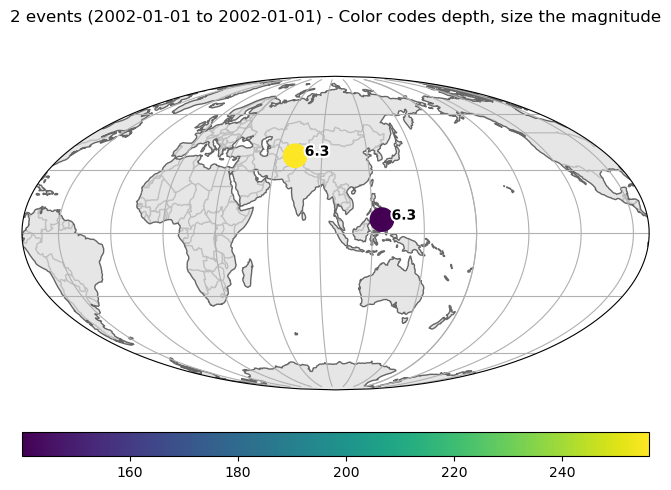

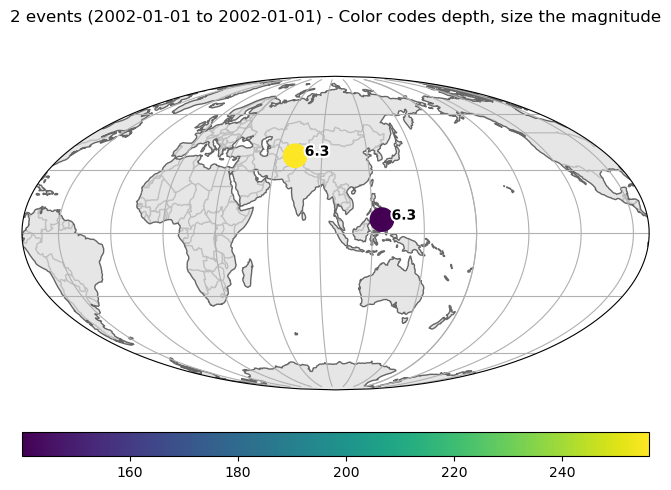

In [3]:
starttime = UTCDateTime("2002-01-01")
endtime = UTCDateTime("2002-01-02")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=6, catalog="ISC")
print(cat)  

cat.plot() 

## Test ES SDK

In [ ]:
import requests
from pathlib import Path
 
from earthscope_sdk.auth.device_code_flow import DeviceCodeFlowSimple
from earthscope_sdk.auth.auth_flow import NoTokensError

def get_es_file(url, directory_to_save_file='./', token_path='./'):
    """function to get earthscope data using es-sdk
    modified from https://gitlab.com/earthscope/public/earthscope-sdk

    Parameters
    ----------
    url : string
        url of desired file at gage-data.earthscope.org
    directory_to_save_file : str, optional
        path of directory in which to save the file, by default cwd
    token_path : str, optional
        path of directory in which to save the token, by default './'
    """
    # instantiate the device code flow subclass
    device_flow = DeviceCodeFlowSimple(Path(token_path))
    try:
      # get access token from local path
      device_flow.get_access_token_refresh_if_necessary()
    except NoTokensError:
      # if no token was found locally, do the device code flow
      device_flow.do_flow()
    token = device_flow.access_token

    # request a file and provide the token in the Authorization header
    file_name = Path(url).name

    r = requests.get(url, headers={"authorization": f"Bearer {token}"})
    if r.status_code == requests.codes.ok:
      # save the file
      with open(Path(Path(directory_to_save_file) / file_name), 'wb') as f:
          for data in r:
              f.write(data)
    else:
      #problem occured
      print(f"failure: {r.status_code}, {r.reason}")

In [ ]:
url='https://gage-data.earthscope.org/archive/gnss/products/velocity/cwu.final_igs14.vel'
get_es_file(url)

In [ ]:
import pandas as pd
df=pd.read_csv("cwu.final_igs14.vel",header=35, delim_whitespace=True)
df=df.drop_duplicates(subset='*Dot#', keep="last")

In [ ]:
import numpy as np
angle = np.degrees(np.arctan2(df["dN/dt"], df["dE/dt"]))
length = np.hypot(df["dN/dt"], df["dE/dt"])

In [ ]:
# West, East, South, North boundaries of the map
region = [-130, -100, 30, 50]

fig = pygmt.Figure()
with fig.subplot(
    nrows=1,
    ncols=2,
    figsize=("35c", "15c"),
    sharey="l",  # shared y-axis on the left side
    frame="WSrt",
):
    with fig.set_panel(0):
        fig.basemap(region=region, projection="M?", frame="af")
        fig.coast(area_thresh=1e4, land="#eeeeee")
        scale_factor = 2 / length.max()
        fig.plot(
            x=df.Ref_Elong,
            y=df.Ref_Nlat,
            direction=[angle, length * scale_factor],
            style="v0.15c+e",
            fill="blue",
            pen="1p,blue",
        )
        # Plot a quiver caption
        fig.plot(
            x=-4,
            y=42,
            direction=[[0], [1 * scale_factor]],
            style="v0.15c+e",
            fill="blue",
            pen="1p,blue",
        )
        fig.text(
            x=-4,
            y=42.2,
            text="1 mm/yr",
            justify="BL",
            font="10p,Helvetica,blue",
        )
    with fig.set_panel(1):
        fig.basemap(region=region, projection="M?", frame="af")
        fig.coast(area_thresh=1e4, land="#eeeeee")
        pygmt.makecpt(
            cmap="polar",
            series=[-.005, .005],
        )
        fig.plot(
            x=df.Ref_Elong,
            y=df.Ref_Nlat,
            fill=df["dU/dt"],
            style="c0.2c",
            cmap=True,
            pen="0.5p,black",
        )
        fig.colorbar(
            frame='af+l"vertical velocity [m/yr]"',
            position="jTL+w7c/0.3c+h+o1/1",
        )
fig.show()

#modified from https://www.fatiando.org/ensaio/latest/gallery/alps-gps-velocity.html